In [1]:
%load_ext autoreload
%autoreload 2

import os

import h5py
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm

import sys
sys.path.insert(1, '../')

from utils.viz import *
from utils.weighted_acc_rmse import unlog_tp
from utils.inference import validation

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

runs = {
    'l1_only': {
        'config_name': 'bs64_l1_only',
    },
    'l1_only_afno': {
        'config_name': 'bs64_l1_only_afno_wind',
    },
    'l1_only_afno_orog': {
        'config_name': 'bs64_l1_only_afno_wind_orog',
    },
    'l1_only_afno_wind_randn': {
        'config_name': 'bs64_l1_only_afno_wind_randn',
    },
    'gan': { 
        'run_name': 'rich-sweep-12',
        'root_path': '/pscratch/sd/j/jpduncan/tsitprecip/experiments/sweeps/weatherbenching/ERA5_generative',
        'sweep_id': 'in3z86on',
        'job_id': '2806185',
        'config_name': 'bs64_ganFeat_l1_pretrained_sweep',
    },
    'v-gan-1': { # wise-sweep-6, after 1 epoch
        'run_name': 'wise-sweep-6',
        'sweep_id': '7sazhaws',
        'run_id': 'emwj38bf',
        'config_name': 'bs64_vae',
    },
    'v-gan-12': { # wise-sweep-6, after 12 epochs
        'run_name': 'wise-sweep-6',
        'sweep_id': '7sazhaws',
        'run_id': 'emwj38bf',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
}

n_gpu = 4

In [2]:
%%time
summaries, bin_edges = validation(runs, global_batch_size=32, num_workers=16,
                                  total_batches=None, # run on full validation set
                                  overwrite=False,
                                  save_root='/global/cfs/cdirs/dasrepo/jpduncan/weatherbenching/ERA5_generative')

loading previously saved summary for "l1_only" run
loading previously saved summary for "l1_only_afno" run
loading previously saved summary for "l1_only_afno_orog" run
loading previously saved summary for "l1_only_afno_wind_randn" run
loading previously saved summary for "gan" run
loading previously saved summary for "v-gan-1" run
loading previously saved summary for "v-gan-12" run
CPU times: user 48.8 ms, sys: 152 ms, total: 201 ms
Wall time: 4.46 s


In [3]:
for name, summary in summaries.items():
    msg = None
    if 'acc' in summary.keys(): 
        print(f'{name:>25} -- ACC: {summary["acc"].mean():.4f} | log L1 binned: {summary["binned_log_l1"].mean():.4f}')

                     afno -- ACC: 0.8053 | log L1 binned: 4.3413
                  l1_only -- ACC: 0.8230 | log L1 binned: 3.9676
             l1_only_afno -- ACC: 0.8243 | log L1 binned: 3.9575
        l1_only_afno_orog -- ACC: 0.8237 | log L1 binned: 3.8196
  l1_only_afno_wind_randn -- ACC: 0.8247 | log L1 binned: 3.9287
                      gan -- ACC: 0.7733 | log L1 binned: 3.7426
                  v-gan-1 -- ACC: 0.8058 | log L1 binned: 3.9891
                 v-gan-12 -- ACC: 0.7533 | log L1 binned: 3.8487


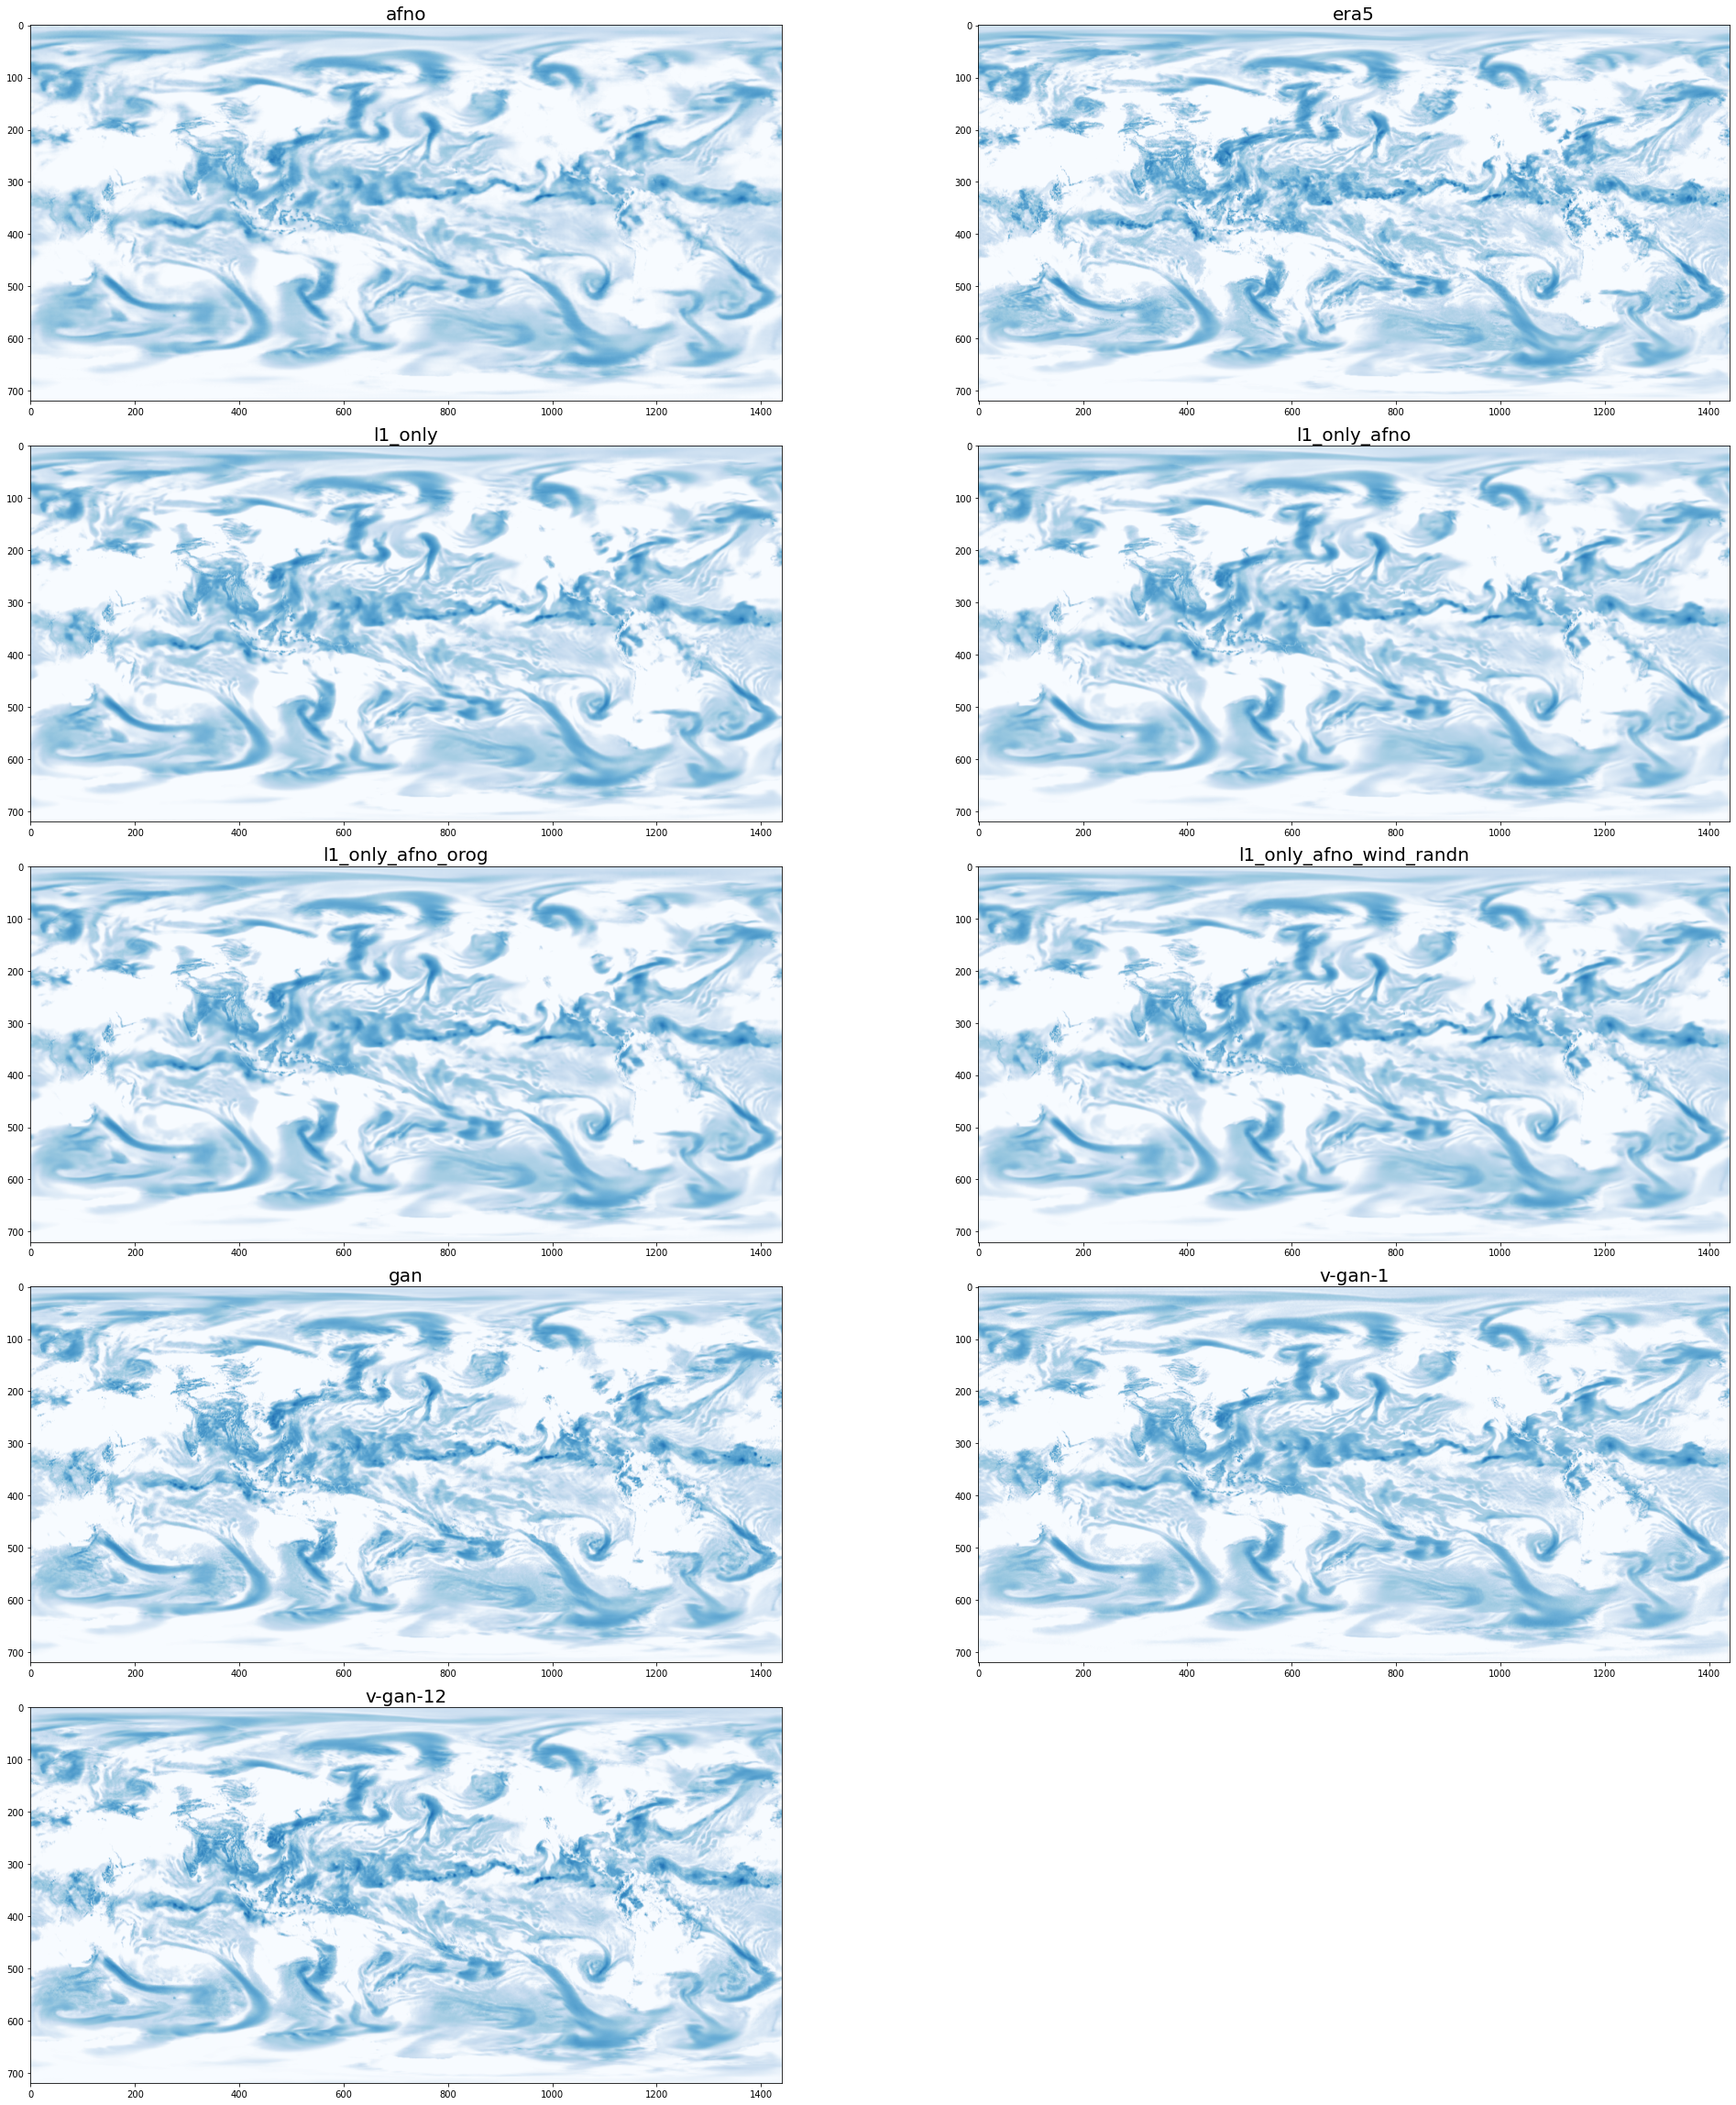

In [4]:
plt.figure(figsize=(30,8*(len(summaries) // 2)))

sc = max([summaries[key]['fields'].max() for key in summaries.keys()])

for i, (name, summary) in enumerate(summaries.items()):
    
    field = summary['fields'][0].squeeze()

    plt.subplot(len(summaries) // 2 + len(summaries) % 2, 2, i+1)
    plt.imshow(field, cmap='Blues', norm=Normalize(0., sc))
    plt.title(name, fontsize=20)
    
plt.tight_layout()
plt.show()

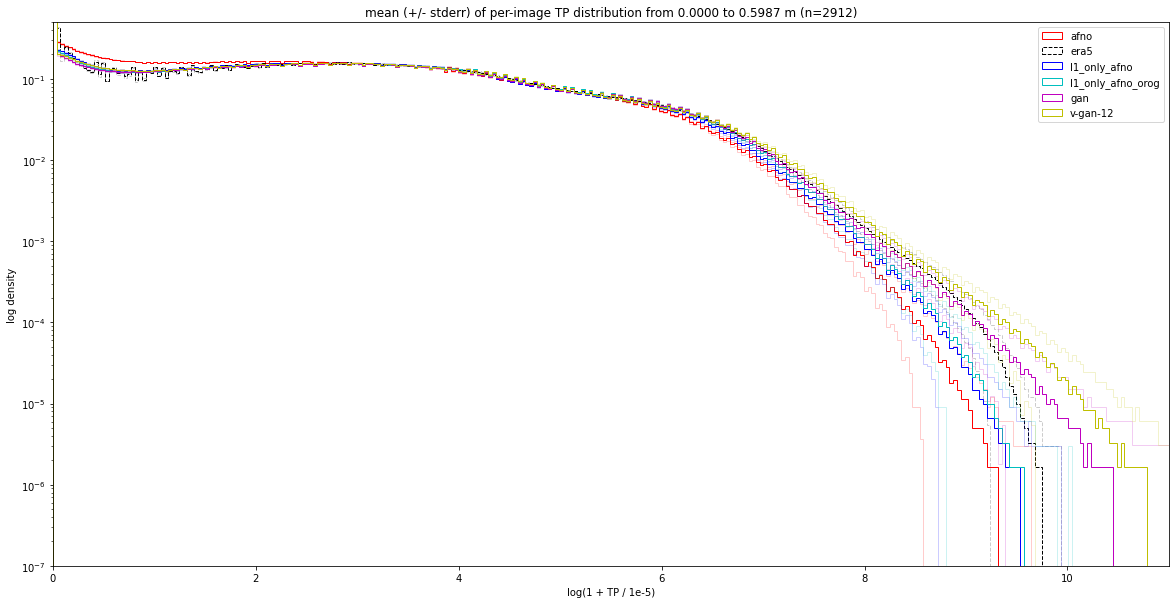

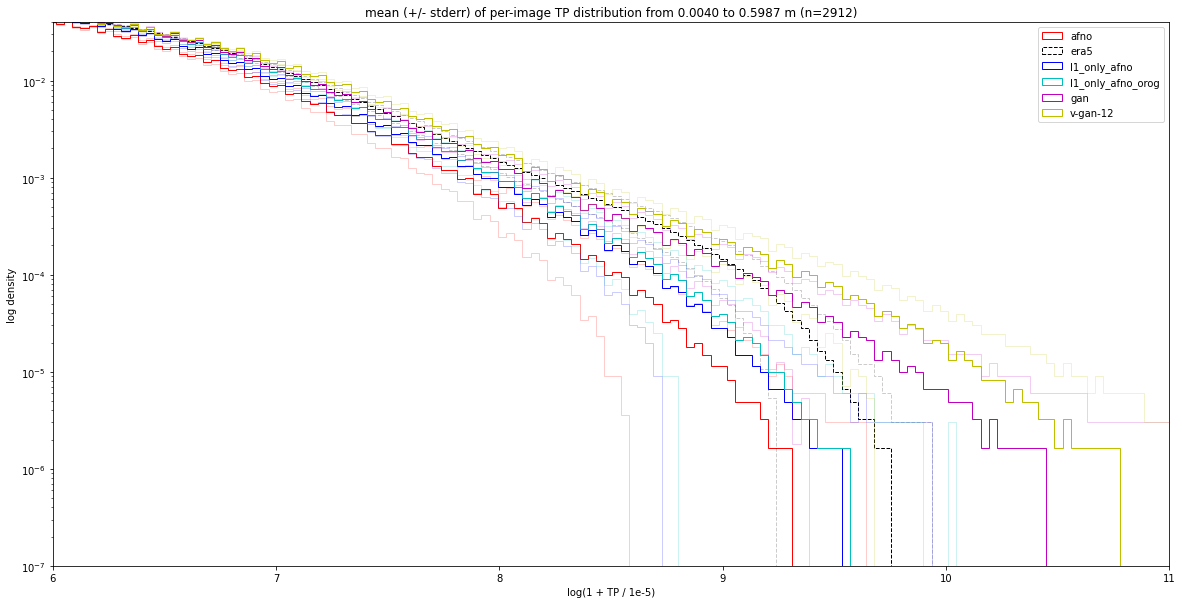

In [5]:
xylims = [((0., 11.), (0.0000001, 0.5)),
              # ((0., 4.), (0.075, 0.325)),
              # ((4., 6.), (0.04, 0.15)),
              ((6., 11.), (0.0000001, 0.04))]

colors = {
    'era5': 'k',
    'afno': 'r',
    'l1_only': 'g',
}
colors_ = ['b', 'c', 'm', 'y', 'darkorange', 'lime', 'cornflowerblue']


n_obs = summaries["era5"]["hists"].shape[0]

plot_keys = ['afno', 'era5', 'l1_only_afno', 'l1_only_afno_orog', 'gan', 'v-gan-12']

for (xlim, ylim) in xylims:
    
    i = 0
    
    plt.figure(figsize=(20, 10))

    for name, summary in [(key, val) for key, val in summaries.items() if key in plot_keys]:
        mean = summary["hists"].mean(axis=0)
        std = summary["hists"].std(axis=0)

        if name in colors.keys():
            color = colors[name]
        else:
            color = colors_[i]
            i += 1
            
        if name == 'era5':
            linestyle = '--'
        else:
            linestyle = '-'

        plt.hist(bin_edges[:-1], bin_edges, weights=mean, density=True, histtype='step', log=True, color=color, linestyle=linestyle, label=name)
        plt.hist(bin_edges[:-1], bin_edges, weights=mean - std, density=True, histtype='step', log=True, color=color, linestyle=linestyle, alpha=0.2)
        plt.hist(bin_edges[:-1], bin_edges, weights=mean + std, density=True, histtype='step', log=True, color=color, linestyle=linestyle, alpha=0.2)
        
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('log(1 + TP / 1e-5)')
    plt.ylabel('log density')
    plt.legend()
    plt.title(f'mean (+/- stderr) of per-image TP distribution from {unlog_tp(xlim[0]):.4f} to {unlog_tp(xlim[1]):.4f} m (n={n_obs})')
    plt.show()

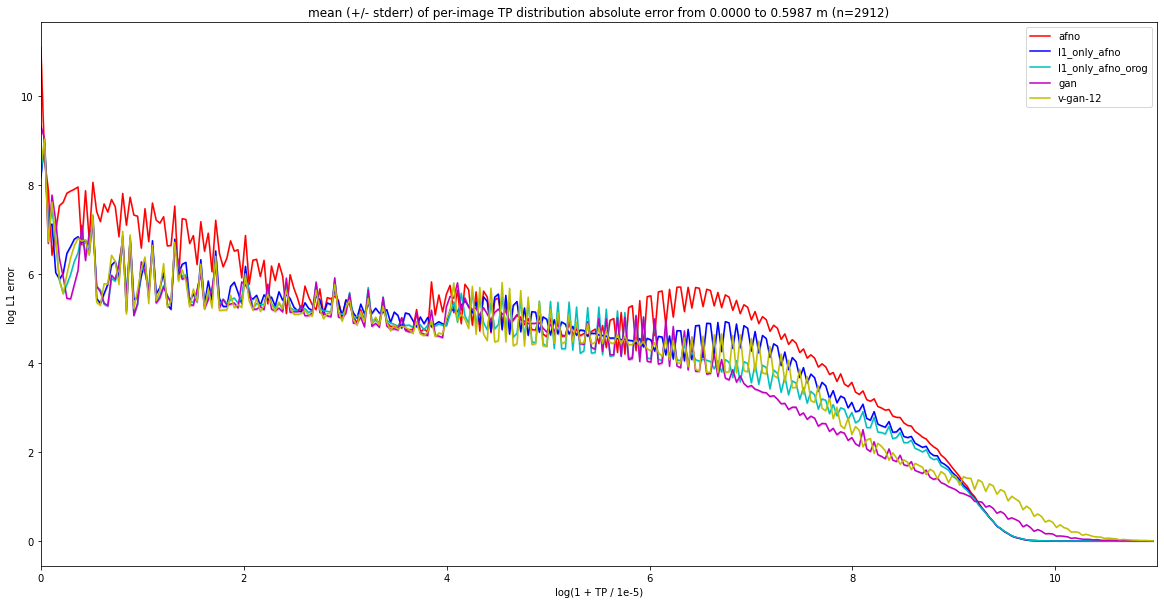

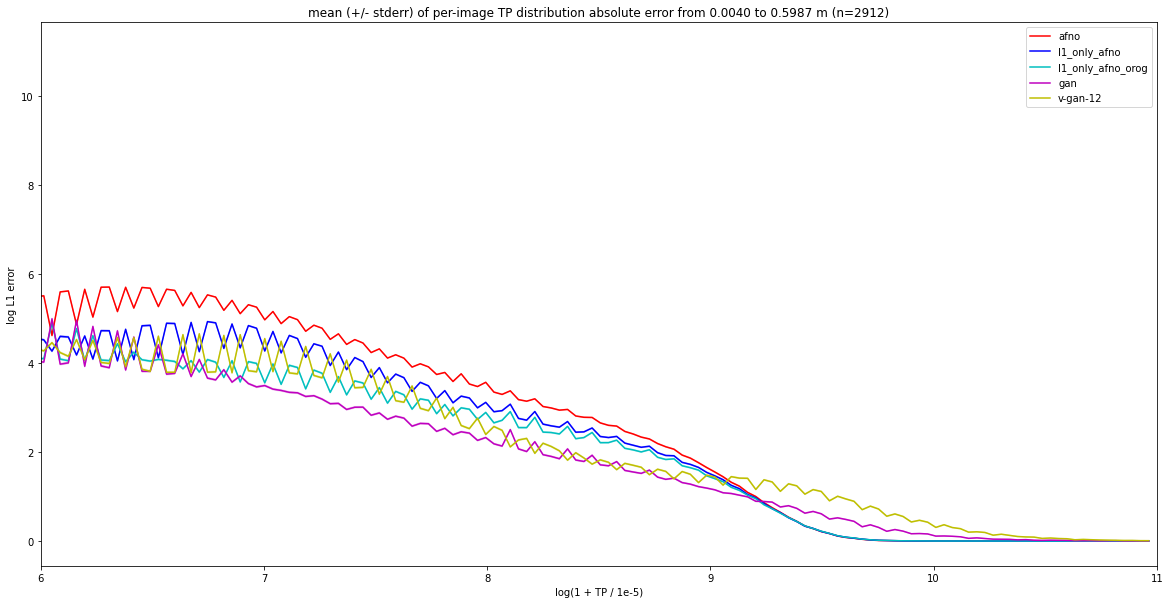

In [6]:
for xlim, _ in xylims:
    
    i = 0
    
    plt.figure(figsize=(20, 10))

    for name, summary in [(key, val) for key, val in summaries.items() if key in plot_keys and not key == 'era5']:
        
        summary = summaries[name]
        
        err = np.log1p(np.abs(summary["hists"] - summaries['era5']["hists"]))
        err_mean = err.mean(axis=0)
        err_stderr = err.std(axis=0) / np.sqrt(n_obs)
        
        if name in colors.keys():
            color = colors[name]
        else:
            color = colors_[i]
            i += 1

        plt.plot(bin_edges[:-1], err_mean, color=color, label=name)
        plt.fill_between(bin_edges[:-1], err_mean - err_stderr, err_mean + err_stderr, color=color, alpha=0.2)
        
    plt.xlim(xlim)
    plt.xlabel('log(1 + TP / 1e-5)')
    plt.ylabel('log L1 error')
    plt.legend()
    plt.title(f'mean (+/- stderr) of per-image TP distribution absolute error from {unlog_tp(xlim[0]):.4f} to {unlog_tp(xlim[1]):.4f} m (n={n_obs})')
    plt.show()

In [8]:
%%time
vae_runs = {
    # bs64_vae_sweep-v1
    'gallant-sweep-9': {
        'run_name': 'gallant-sweep-9',
        'sweep_id': '7sazhaws',
        'run_id': 'v7pg65o8',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    'absurd-sweep-13': {
        'run_name': 'absurd-sweep-13',
        'sweep_id': '7sazhaws',
        'run_id': 'xo36phk4',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    'brisk-sweep-16': {
        'run_name': 'brisk-sweep-16',
        'sweep_id': '7sazhaws',
        'run_id': 'gd1ef42k',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    'dandy-sweep-8': {
        'run_name': 'dandy-sweep-8',
        'sweep_id': '7sazhaws',
        'run_id': 'vhv6qa3s',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    'misty-sweep-14': {
        'run_name': 'dandy-sweep-8',
        'sweep_id': '7sazhaws',
        'run_id': 'i9r7al88',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    # bs64_vae_sweep-v2
    'whole-sweep-8': {
        'run_name': 'whole-sweep-8',
        'sweep_id': '71xz89oo',
        'run_id': 'y24q2lg9',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    'grateful-sweep-5': {
        'run_name': 'grateful-sweep-5',
        'sweep_id': '71xz89oo',
        'run_id': 'nk311ldw',
        'config_name': 'bs64_vae',
        'use_best': False,
    },
    #  bs64_ganFeat_vae_sweep-v2
    'lunar-sweep-4': {
        'run_name': 'lunar-sweep-4',
        'root_path': '/pscratch/sd/j/jpduncan/tsitprecip/experiments/sweeps/weatherbenching/ERA5_generative',
        'sweep_id': 'y1z23w1f',
        'run_id': '016ul9g3',
        'config_name': 'bs64_ganFeat_vae_sweep',
        'use_best': False,
    },
    'vague-sweep-2': {
        'run_name': 'vague-sweep-2',
        'root_path': '/pscratch/sd/j/jpduncan/tsitprecip/experiments/sweeps/weatherbenching/ERA5_generative',
        'sweep_id': 'y1z23w1f',
        'run_id': 'plctaen0',
        'config_name': 'bs64_ganFeat_vae_sweep',
        'use_best': False,
    },
    'hopeful-sweep-3': {
        'run_name': 'hopeful-sweep-3',
        'root_path': '/pscratch/sd/j/jpduncan/tsitprecip/experiments/sweeps/weatherbenching/ERA5_generative',
        'sweep_id': 'y1z23w1f',
        'run_id': '63ln59oa',
        'config_name': 'bs64_ganFeat_vae_sweep',
        'use_best': False,
    },
    # other
    'bs64_ganFeat_vae': {
        'run_path': '/pscratch/sd/j/jpduncan/tsitprecip/experiments/expts/bs64_ganFeat_vae',
        'config_name': 'bs64_ganFeat_vae',
        'use_best': False,
    }
}

vae_summaries, _ = validation(vae_runs, global_batch_size=32, num_workers=16,
                              total_batches=10,
                              overwrite=False,
                              save_root='/global/cfs/cdirs/dasrepo/jpduncan/weatherbenching/ERA5_generative')

loading previously saved summary for "gallant-sweep-9" run
loading previously saved summary for "absurd-sweep-13" run
loading previously saved summary for "brisk-sweep-16" run
loading previously saved summary for "dandy-sweep-8" run
loading previously saved summary for "misty-sweep-14" run
loading previously saved summary for "whole-sweep-8" run
loading previously saved summary for "grateful-sweep-5" run
validating "lunar-sweep-4" run
Network [TSITGenerator] was created. Total number of parameters: 415.3 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 2.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 415.3 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 2.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 415.3 mi

2022-08-21 21:36:12,076 - root - INFO - Getting file stats from /pscratch/sd/s/shas1693/data/era5/test/2016.h5
2022-08-21 21:36:12,078 - root - INFO - Number of samples per year: 1460
2022-08-21 21:36:12,078 - root - INFO - Found data at path /pscratch/sd/s/shas1693/data/era5/test. Number of examples: 2920. Image Shape: 720 x 1440 x 20
2022-08-21 21:36:12,078 - root - INFO - Delta t: 6 hours
2022-08-21 21:36:12,078 - root - INFO - Including 0 hours of past history in training at a frequency of 6 hours
  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3839: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
100%|███████

validating "vague-sweep-2" run
Network [TSITGenerator] was created. Total number of parameters: 415.3 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 2.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 415.3 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 2.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 415.3 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 2.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 415.3 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 2.6 million. To see the architecture, do print(net

2022-08-21 21:37:52,410 - root - INFO - Getting file stats from /pscratch/sd/s/shas1693/data/era5/test/2016.h5
2022-08-21 21:37:52,411 - root - INFO - Number of samples per year: 1460
2022-08-21 21:37:52,411 - root - INFO - Found data at path /pscratch/sd/s/shas1693/data/era5/test. Number of examples: 2920. Image Shape: 720 x 1440 x 20
2022-08-21 21:37:52,411 - root - INFO - Delta t: 6 hours
2022-08-21 21:37:52,412 - root - INFO - Including 0 hours of past history in training at a frequency of 6 hours
100%|██████████| 10/10 [01:00<00:00,  6.08s/it]


validating "hopeful-sweep-3" run
Network [TSITGenerator] was created. Total number of parameters: 411.1 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 1.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 411.1 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 1.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 411.1 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 1.6 million. To see the architecture, do print(network).
Network [TSITGenerator] was created. Total number of parameters: 411.1 million. To see the architecture, do print(network).
Network [ConvEncoder] was created. Total number of parameters: 1.6 million. To see the architecture, do print(n

2022-08-21 21:39:27,637 - root - INFO - Getting file stats from /pscratch/sd/s/shas1693/data/era5/test/2016.h5
2022-08-21 21:39:27,638 - root - INFO - Number of samples per year: 1460
2022-08-21 21:39:27,639 - root - INFO - Found data at path /pscratch/sd/s/shas1693/data/era5/test. Number of examples: 2920. Image Shape: 720 x 1440 x 20
2022-08-21 21:39:27,639 - root - INFO - Delta t: 6 hours
2022-08-21 21:39:27,639 - root - INFO - Including 0 hours of past history in training at a frequency of 6 hours
100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


loading previously saved summary for "bs64_ganFeat_vae" run
CPU times: user 1h 11min 48s, sys: 4min 39s, total: 1h 16min 27s
Wall time: 4min 48s


In [9]:
for name, summary in vae_summaries.items():
    if 'acc' in summary.keys(): 
        print(f'{name:>25} -- ACC: {summary["acc"].mean():.4f} | log L1 binned: {summary["binned_log_l1"].mean():.4f}')

                     afno -- ACC: 0.8053 | log L1 binned: 4.3413
          gallant-sweep-9 -- ACC: 0.4735 | log L1 binned: 3.8668
          absurd-sweep-13 -- ACC: 0.7469 | log L1 binned: 3.7996
           brisk-sweep-16 -- ACC: 0.7426 | log L1 binned: 4.0826
            dandy-sweep-8 -- ACC: 0.7344 | log L1 binned: 4.0268
           misty-sweep-14 -- ACC: 0.7344 | log L1 binned: 4.0268
            whole-sweep-8 -- ACC: 0.6663 | log L1 binned: 4.0443
         grateful-sweep-5 -- ACC: 0.4157 | log L1 binned: 3.7813
            lunar-sweep-4 -- ACC: 0.7534 | log L1 binned: 3.7898
            vague-sweep-2 -- ACC: 0.7324 | log L1 binned: 3.8672
          hopeful-sweep-3 -- ACC: 0.7757 | log L1 binned: 3.7591
         bs64_ganFeat_vae -- ACC: 0.7355 | log L1 binned: 3.7678


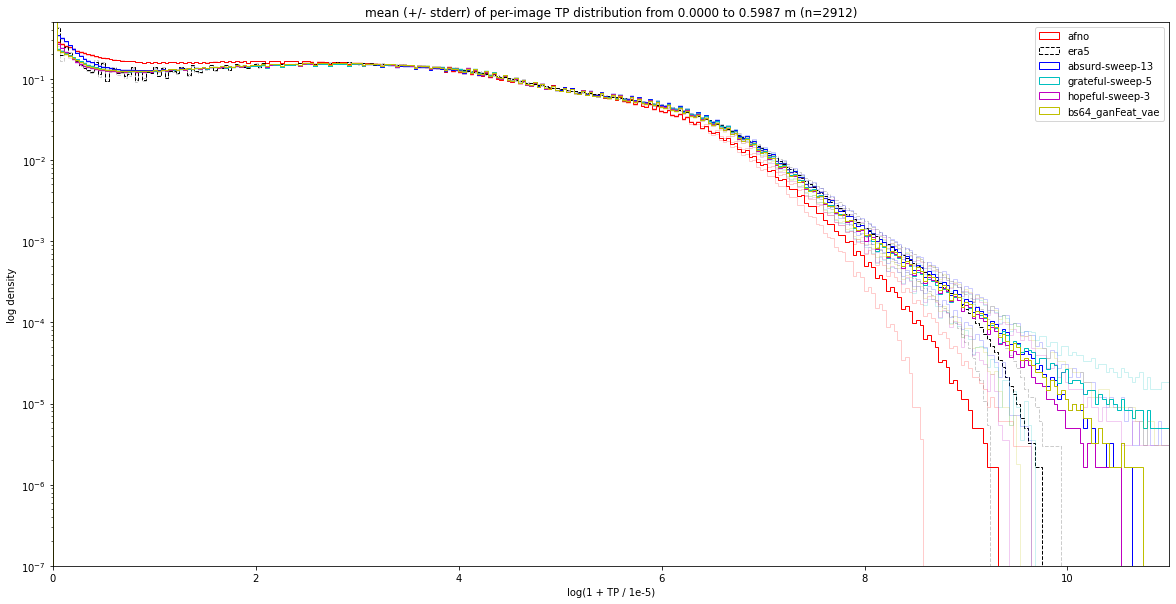

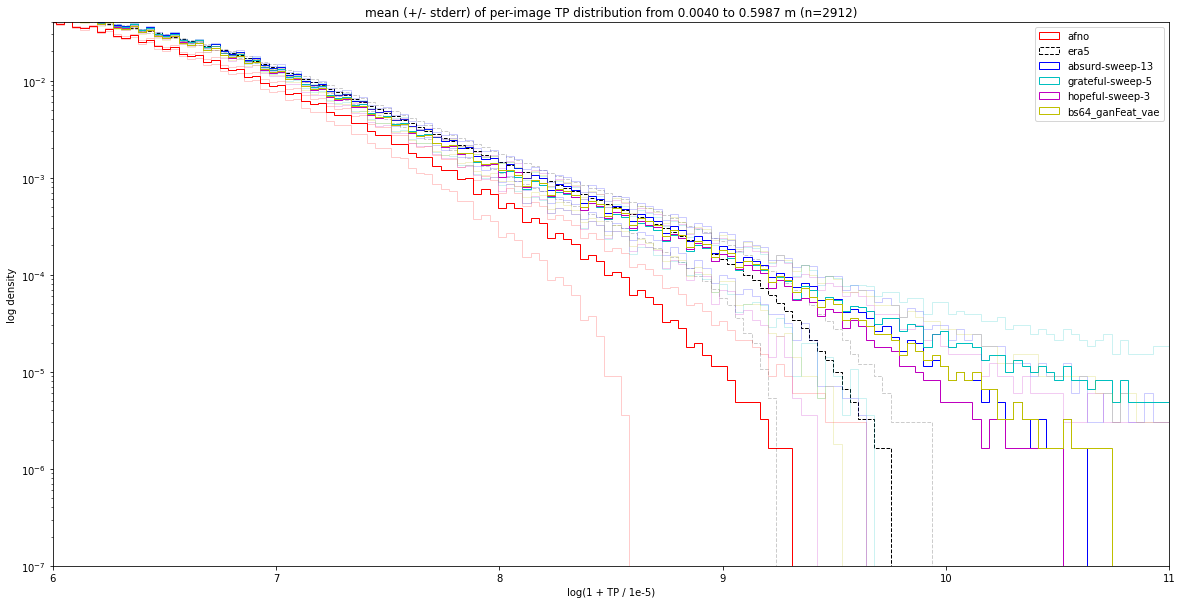

In [10]:
xylims = [((0., 11.), (0.0000001, 0.5)),
              # ((0., 4.), (0.075, 0.325)),
              # ((4., 6.), (0.04, 0.15)),
              ((6., 11.), (0.0000001, 0.04))]

colors = {
    'era5': 'k',
    'afno': 'r',
    'l1_only': 'g',
}
colors_ = ['b', 'c', 'm', 'y', 'darkorange', 'lime', 'cornflowerblue']


n_obs = summaries["era5"]["hists"].shape[0]

plot_keys = ['afno', 'era5', 'absurd-sweep-13', 'grateful-sweep-5', 'hopeful-sweep-3', 'bs64_ganFeat_vae']

for (xlim, ylim) in xylims:
    
    i = 0
    
    plt.figure(figsize=(20, 10))

    for name, summary in [(key, val) for key, val in vae_summaries.items() if key in plot_keys]:
        mean = summary["hists"].mean(axis=0)
        std = summary["hists"].std(axis=0)

        if name in colors.keys():
            color = colors[name]
        else:
            color = colors_[i]
            i += 1
            
        if name == 'era5':
            linestyle = '--'
        else:
            linestyle = '-'

        plt.hist(bin_edges[:-1], bin_edges, weights=mean, density=True, histtype='step', log=True, color=color, linestyle=linestyle, label=name)
        plt.hist(bin_edges[:-1], bin_edges, weights=mean - std, density=True, histtype='step', log=True, color=color, linestyle=linestyle, alpha=0.2)
        plt.hist(bin_edges[:-1], bin_edges, weights=mean + std, density=True, histtype='step', log=True, color=color, linestyle=linestyle, alpha=0.2)
        
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('log(1 + TP / 1e-5)')
    plt.ylabel('log density')
    plt.legend()
    plt.title(f'mean (+/- stderr) of per-image TP distribution from {unlog_tp(xlim[0]):.4f} to {unlog_tp(xlim[1]):.4f} m (n={n_obs})')
    plt.show()

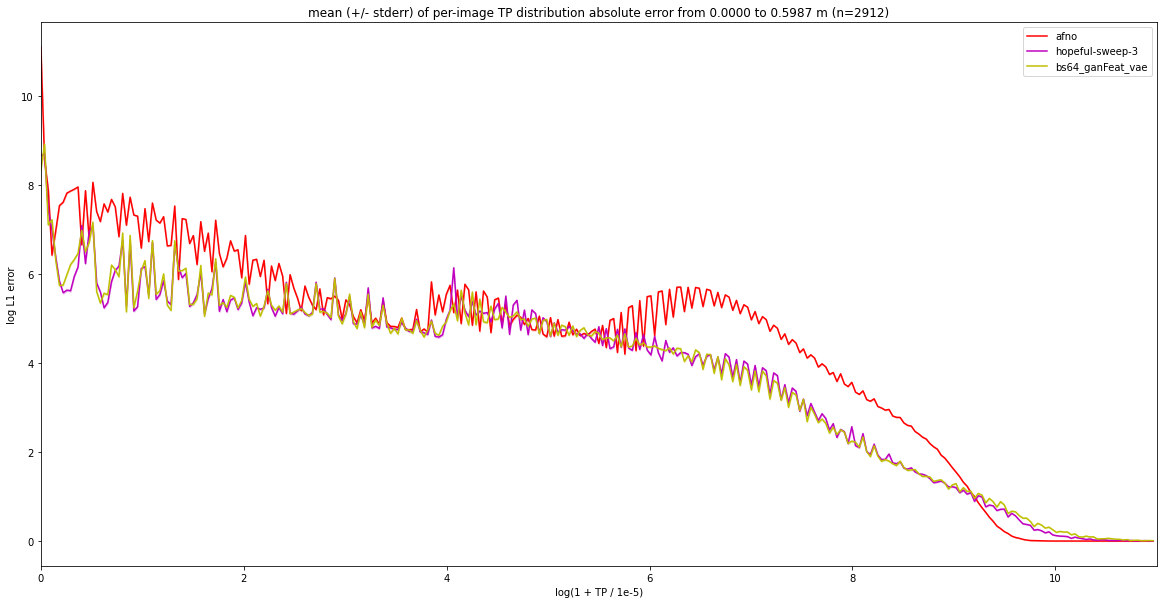

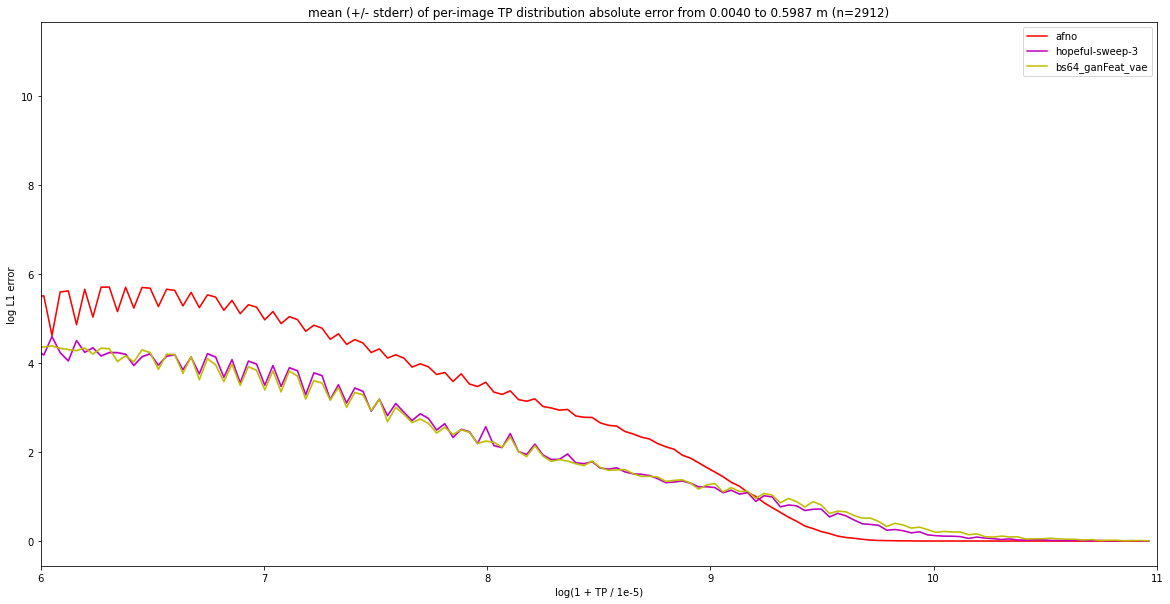

In [12]:
plot_keys = ['afno', 'era5', 'hopeful-sweep-3', 'bs64_ganFeat_vae']
colors['hopeful-sweep-3'] = 'm'
colors['bs64_ganFeat_vae'] = 'y'

for xlim, _ in xylims:
    
    i = 0
    
    plt.figure(figsize=(20, 10))

    for name, summary in [(key, val) for key, val in vae_summaries.items() if key in plot_keys and key != 'era5']:
        
        summary = vae_summaries[name]
        
        err = np.log1p(np.abs(summary["hists"] - vae_summaries['era5']["hists"][:summary["hists"].shape[0], :]))
        err_mean = err.mean(axis=0)
        err_stderr = err.std(axis=0) / np.sqrt(n_obs)
        
        if name in colors.keys():
            color = colors[name]
        else:
            color = colors_[i]
            i += 1

        plt.plot(bin_edges[:-1], err_mean, color=color, label=name)
        plt.fill_between(bin_edges[:-1], err_mean - err_stderr, err_mean + err_stderr, color=color, alpha=0.2)
        
    plt.xlim(xlim)
    plt.xlabel('log(1 + TP / 1e-5)')
    plt.ylabel('log L1 error')
    plt.legend()
    plt.title(f'mean (+/- stderr) of per-image TP distribution absolute error from {unlog_tp(xlim[0]):.4f} to {unlog_tp(xlim[1]):.4f} m (n={n_obs})')
    plt.show()